In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)
logging.getLogger('fgclassifier.features').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

In [3]:
from config import full_train_data_path, full_valid_data_path
from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(full_train_data_path)
X_valid, y_valid = read_data(full_valid_data_path)
X_train.shape

2018-12-07 20:45:24,852 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv.tokenized.csv..
2018-12-07 20:45:27,115 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv.tokenized.csv..


(105000,)

In [4]:
from sklearn.pipeline import Pipeline
from fgclassifier.features import Count, Tfidf

# Build vocabulary, using all training and testing datasets
count = Count(max_features=12000,
              ngram_range=(1, 5),
              min_df=5, max_df=0.7)
x_train = count.fit_transform(X_train)

2018-12-07 20:45:32,640 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-07 20:53:34,026 [INFO] Vocab Size: 12000


In [6]:
x_valid = count.transform(X_valid)

In [7]:
vocab = count.vocabulary_

In [8]:
print(x_train.shape, x_valid.shape)

(105000, 12000) (15000, 12000)


In [10]:
from collections import Counter

# total counts of all 12000 words
docfreq = np.sum(x_train != 0, axis=0).flat

# term to doc freq dictionary
term2docfreq = {k: docfreq[v] for k, v in vocab.items()}

print('\nvocab size: %s\n' % len(vocab))
if count.stop_words_:
    print('\nStop words size: %s\n' % len(count.stop_words_))

# Remove stop words as they take a lot of memory
count.stop_words_ = None

print('Words with highest document frequency:')
print('\n'.join([
    '%s \t %s' % (k, v)
    for k, v in Counter(term2docfreq).most_common()[:10]]))


vocab size: 12000

Words with highest document frequency:
不错 	 64034
味道 	 64029
可以 	 53174
感觉 	 52982
还是 	 49282
好吃 	 48335
没有 	 45937
就是 	 44515
比较 	 40346
环境 	 38773


## Optimize classifier 

We use TruncatedSVD for dimension reduction, then pass the reduced dataset
to LDA. This is more efficient as this way we can handle sparse matrix whereas
LDA requires dense matrix input.

In [76]:
np.linspace(1000, 20000, 20, dtype=int)

array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000, 20000])

In [75]:
np.linspace(500, 8000, 16, dtype=int)

array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500,
       6000, 6500, 7000, 7500, 8000])

In [23]:
np.array(docfreq).shape

(12000,)

In [78]:
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin

from fgclassifier.features import logger, BaseEstimator
from fgclassifier.features import Count, Tfidf, SVD, SmartSVD, SparseToDense
from fgclassifier.baseline import Baseline, MultiOutputClassifier
from fgclassifier.classifiers import LDA, SGDClassifier, LinearDiscriminantAnalysis


def get_estimator(name):
    penalty = 'L1' if 'L1' in name else 'L2'
    estimator = None
    if name == 'LDA':
        estimator = LinearDiscriminantAnalysis()
    elif 'Logistic' in name:
        estimator = SGDClassifier(
            loss='log',
            penalty=penalty,
            early_stopping=True,
            n_jobs=-1,
            learning_rate='optimal', class_weight='balanced',
            max_iter=5000, tol=1e-4, alpha=1e-4
        )
    elif 'SVC' in name:
        estimator = SGDClassifier(
            loss='hinge',
            penalty=penalty,
            early_stopping=True,
            n_jobs=-1,
            learning_rate='optimal', class_weight='balanced',
            max_iter=5000, tol=1e-4, alpha=1e-4
        )
    if estimator is not None:
        estimator.name = name
    return estimator



class FeatureLimiter(BaseEstimator, TransformerMixin):
    
    def __init__(self, idx):
        self.idx = idx
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.idx]
    
    
class SampleLimiter(BaseEstimator, TransformerMixin):
    """Limit number of training samples"""
    
    def __init__(self, limit):
        self.limit = limit
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return X[:self.limit, :]

    def transform(self, X):
        return X
    
    

class VocabLimiter(FeatureLimiter):
    """Limit vocabulary index
    based on pre-computed frequency dict
    
    Arguments:
    --------------
        limit:  maximum number of terms
    """
    
    def __init__(self, limit, freqs):
        self.limit = limit
        self.freqs = freqs
        if freqs is not None:
            pct = limit / freqs.shape[0]
            freqlimit = np.quantile(freqs, pct)
            logger.info('Limit to %d (%.2f%%) vocab', limit, pct * 100)
            super(VocabLimiter, self).__init__(idx=freqs < freqlimit)


clf = Pipeline([
#     ('sample_limiter', SampleLimiter(limit=100)),
    ('feature_limiter', VocabLimiter(limit=100, freqs=np.array(docfreq))),
    ('tfidf', Tfidf()),
    ('clf', MultiOutputClassifier(estimator=get_estimator('LDA')))
])

feature_limits = np.linspace(500, 8000, 16, dtype=int)
sample_limits = np.linspace(1000, 20000, 20, dtype=int)

parameters = {
#     'sample_limiter__limit': sample_limits, 
    'feature_limiter__limit': feature_limits, 
    'clf__estimator': [get_estimator(x) for x in [
        'SVC w/ L1', 'Logistic w/ L1',
        'SVC w/ L2', 'Logistic w/ L2'
    ]]
}
parameters_lda = parameters.copy()
parameters_lda['clf__estimator'] = get_estimator('LDA')


with joblib.parallel_backend('threading', n_jobs=1):
    searcher = GridSearchCV(
        clf, parameters, cv=3,
        verbose=True,
        return_train_score=True
    )
    searcher.fit(x_train[:1000], y_train[:1000])

clear_output()

In [79]:
searcher.best_estimator_.named_steps

{'feature_limiter': VocabLimiter(freqs=array([ 395, 7685, ...,  118,  216], dtype=int64),
        limit=3500),
 'tfidf': Tfidf(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'clf': MultiOutputClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
        early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5000,
        n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='L2',
        power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
        validation_fraction=0.1, verbose=0, warm_start=False),
            n_jobs=None)}

In [83]:
import seaborn as sns

def extract_results(searcher, params):
    """Process the results for display"""
    colnames = [f'param_{x}' for x in params]
    results =  pd.melt(
        pd.DataFrame(searcher.cv_results_),
        id_vars=colnames,
        value_vars=[
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
#             'split3_test_score',
#             'split4_test_score',
            'split0_train_score',
            'split1_train_score',
            'split2_train_score',
#             'split3_train_score',
#             'split4_train_score',
        ],
        value_name='score'
    )
    results.columns = params + ['variable', 'score']
    results['train_or_test'] = np.where(results['variable'].str.contains('test'),
                                        'test', 'train')
    results = results.drop(['variable'], axis=1)
    return results

results = extract_results(searcher, ['clf__estimator', 'feature_limiter__limit'])
results.columns = ['clf', 'vocab_size', 'score', 'train_or_test']
results['clf'] = results['clf'].apply(lambda x: x.name)
results.sample(5)

,clf,vocab_size,score,train_or_test
134,SVC w/ L1,3500,0.166309,test
91,Logistic w/ L1,6000,0.205527,test
296,SVC w/ L2,4500,0.273502,train
233,SVC w/ L2,5000,0.264199,train
372,Logistic w/ L2,2500,0.288794,train


In [84]:
results.dtypes

clf               object
vocab_size        object
score            float64
train_or_test     object
dtype: object

/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


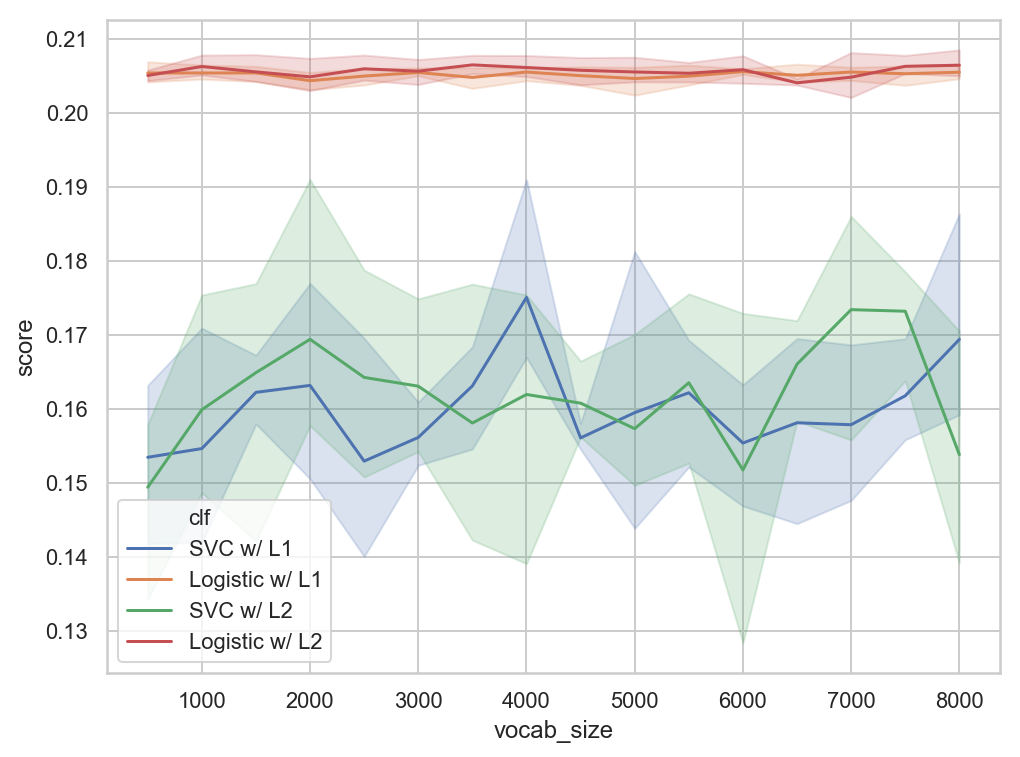

In [85]:
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

a = sns.lineplot(
    x='vocab_size',
    y='score',
    hue='clf',
    data=results[results['train_or_test'] == 'test'],
    ax=ax
)

Looks like the LDA paramater does not matter for LDA.

In [106]:
from fgclassifier.classifiers import SGDClassifier
from fgclassifier.utils import logger, save_model

import logging

logging.getLogger('fgclassifier.baseline').setLevel(logging.DEBUG)


SGD_Logistic = SGDClassifier(
    loss='log',
    learning_rate='optimal',
    class_weight='balanced',
    penalty='L1',
    n_jobs=-1,
    early_stopping=True,
    max_iter=4000,
    tol=1e-5,
    alpha=1e-4
)

clf = Pipeline([
    ('vect', Count(
        vocabulary=vocab,
        max_features=5000
    )),
    ('tfidf', Tfidf()),
    ('clf', MultiOutputClassifier(SGD_Logistic))
])


with joblib.parallel_backend('threading', n_jobs=3):
    logger.info('Train...')
    clf.fit(X_train, y_train)
    logger.info('Validate...')
    score = clf.score(X_valid, y_valid)

2018-12-07 18:22:22,786 [INFO] Train...
2018-12-07 18:22:33,056 [INFO] Vocab Size: 6000
2018-12-07 18:22:56,129 [INFO] Validate...
2018-12-07 18:22:58,590 [DEBUG]   location_traffic_convenience            	0.4760
2018-12-07 18:22:58,597 [DEBUG]   location_distance_from_business_district	0.3620
2018-12-07 18:22:58,602 [DEBUG]   location_easy_to_find                   	0.5440
2018-12-07 18:22:58,609 [DEBUG]   service_wait_time                       	0.5225
2018-12-07 18:22:58,615 [DEBUG]   service_waiters_attitude                	0.6315
2018-12-07 18:22:58,620 [DEBUG]   service_parking_convenience             	0.5103
2018-12-07 18:22:58,625 [DEBUG]   service_serving_speed                   	0.5318
2018-12-07 18:22:58,632 [DEBUG]   price_level                             	0.5912
2018-12-07 18:22:58,637 [DEBUG]   price_cost_effective                    	0.5658
2018-12-07 18:22:58,643 [DEBUG]   price_discount                          	0.5671
2018-12-07 18:22:58,655 [DEBUG]   environment_dec